# Bag of words model

In [1]:
import numpy as np

from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear
from torch.nn.functional import softmax, relu, tanh
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook, show, push_notebook
output_notebook()


Loading BokehJS ...

In [3]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

## SST

In [4]:
TEXT = data.Field(sequential=True)
LABEL = data.Field(sequential=False)

train_set, validation_set, _ = datasets.SST.splits(TEXT,
                                                    LABEL,
                                                    fine_grained=False,
                                                    train_subtrees=True,
                                                    filter_pred=lambda ex: ex.label != 'neutral')

In [5]:
print('train.fields', train_set.fields)
print('len(train)', len(train_set))
print('vars(train[0])', vars(train_set[0]))
print()
print('Example 2', vars(train_set[17]))

train.fields {'text': <torchtext.data.field.Field object at 0x000001D400ED2C18>, 'label': <torchtext.data.field.Field object at 0x000001D400ED2C50>}
len(train) 98794
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}

Example 2 {'text': ['The', 'gorgeously', 'elaborate', 'continuation', 'of', '``', 'The', 'Lord', 'of', 'the', 'Rings', "''", 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'can', 'not', 'adequately', 'describe', 'co-writer\\/director', 'Peter', 'Jackson', "'s", 'expanded', 'vision', 'of', 'J.R.R.', 'Tolkien', "'s", 'Middle-earth', '.'], 'label': 'positive'}


In [6]:
# build the vocabulary
url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
#url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
TEXT.build_vocab(train_set, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
#TEXT.build_vocab(train_set,vectors=GloVe(name='840B',dim='300'))
LABEL.build_vocab(train_set)
# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())


len(TEXT.vocab) 18005
TEXT.vocab.vectors.size() torch.Size([18005, 300])


In [7]:
# make iterator for splits
train_iter, val_iter, _ = data.BucketIterator.splits(
    (train_set, validation_set, _), batch_size=32)


# print batch information
#batch = next(iter(train_iter))
batchsst = next(iter(train_iter))
print(batchsst.text.size())
print(batchsst.label)

torch.Size([26, 32])
tensor([2, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2,
        1, 1, 1, 2, 1, 1, 2, 2])


In [8]:
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

dropout_rate = 0.2

input_dim = 200

con_dim = 200

# build the BoW model
class BoWNet(nn.Module):

    def __init__(self):
        super(BoWNet, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)
        
        # add hidden layers
        # YOUR CODE HERE!
        
        self.input = Linear(in_features = embedding_dim,
                             out_features = input_dim,
                             bias = True)
        
        self.l_1 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias = True)
        self.l_2 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias= True)
        self.l_3 = Linear(in_features= con_dim,
                           out_features = con_dim,
                           bias = True)
        
        self.drop = nn.Dropout(p = dropout_rate)
        
        # output layer
        self.l_out = Linear(in_features=con_dim,
                            out_features=num_classes,
                            bias=False)
        
    def forward(self, x):
        out = {}
        # get embeddings
        x = self.embeddings(x) # (bs,len,300)
        #y = self.embeddings(y)
        
        x = self.drop(x)
        #y = self.drop(y)
        
        #sum_x =  # (bs,300) 

        
        sum_x = torch.sum(x,0)
        #sum_y = torch.sum(y,0)
        
        
        #tanh # (bs,100)
        
        sum_x = torch.tanh(self.input(sum_x))
        #sum_y = torch.tanh(self.input(sum_y))
    
        #z = torch.cat((sum_x,sum_y),1)
        z = sum_x
        
        z = torch.tanh(self.l_1(z))     
        z = torch.tanh(self.l_2(z))
        z = torch.tanh(self.l_3(z))

        # Softmax
        out['out'] = softmax(self.l_out(z), dim = 1)
        return out

net = BoWNet()
print(net)

BoWNet(
  (embeddings): Embedding(18005, 300)
  (input): Linear(in_features=300, out_features=200, bias=True)
  (l_1): Linear(in_features=200, out_features=200, bias=True)
  (l_2): Linear(in_features=200, out_features=200, bias=True)
  (l_3): Linear(in_features=200, out_features=200, bias=True)
  (drop): Dropout(p=0.2)
  (l_out): Linear(in_features=200, out_features=3, bias=False)
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001,amsgrad=True,weight_decay=0.00001)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

In [10]:
def construct_sentences(batch):
    """    
    Parameters
    ----------
    batch: torchtext.data.batch.Batch
    
    Returns
    -------
    [str]
    """
    return [" ".join([TEXT.vocab.itos[elm] 
                      for elm in get_numpy(batch.text[:,i])])
            for i in range(batch.text.size()[1])]

def get_labels(batch):
    """
    Parameters
    ----------
    batch: torchtext.data.batch.Batch
    
    Returns
    -------
    [str]
    """
    return [LABEL.vocab.itos[get_numpy(batch.label[i])] for i in range(len(batch.label))]


In [11]:
#derp = next(iter(val_iter))
#print(derp.text[0])

## TRAINING BOW WITH SST

In [34]:
max_iter = 100
eval_every = 100
log_every = 50

train_loss, train_accs, train_iter_list = [], [], []
train_loss_list, train_accs_list = [],[]
val_loss_list, val_accs_list, val_iter_list = [],[], []


max_acc = 0
max_acc_idx = 0
epochs = 1
reached_max = False

net.train()
while reached_max == False:
    print("EPOCH NR: " + str(epochs))
    for i, batch in enumerate(train_iter):
        if i > max_iter:
            break
        if i % eval_every == 0:
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
      #  val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
            for val_batch in val_iter:
                output = net(val_batch.text)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
                val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
                val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
                val_lengths += val_batch.batch_size
            

        
        # divide by the total accumulated batch sizes
            val_losses /= val_lengths
            val_accs /= val_lengths
        
            val_loss_list.append(get_numpy(val_losses))
            val_accs_list.append(get_numpy(val_accs))
            val_iter_list.append(i)
        
            print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        #update_plot(val_meta, 'bow', tsne_plot)
        
            net.train()
    
        output = net(batch.text)
        batch_loss = criterion(output['out'], batch.label)
    
        train_loss.append(get_numpy(batch_loss))
        train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
 
    
        optimizer.zero_grad()
        batch_loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),max_norm=0.5)
        optimizer.step()
    
        if i % log_every == 0:        
            print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
            train_loss_list.append(np.mean(train_loss))
            train_accs_list.append(np.mean(train_accs))    
            train_iter_list.append(i)
            train_loss, train_accs = [], []
    if max(val_accs_list[max_acc_idx:len(val_accs_list)]) > max_acc:
        max_acc = max(val_accs_list[max_acc_idx:len(val_accs_list)])
        max_acc_idx = np.argmax(max(val_accs_list[max_acc_idx:len(val_accs_list)]))
    else:
        print("Maximum validation accuracy: " + str(max_acc))
        reached_max = True
        break
    epochs += 1

EPOCH NR: 1
valid, it: 0 loss: 0.82 accs: 0.72

train, it: 0 loss: 0.75 accs: 0.81
train, it: 50 loss: 0.75 accs: 0.79
valid, it: 100 loss: 0.79 accs: 0.76

train, it: 100 loss: 0.75 accs: 0.79
EPOCH NR: 2
valid, it: 0 loss: 0.78 accs: 0.76

train, it: 0 loss: 0.77 accs: 0.78
train, it: 50 loss: 0.74 accs: 0.81
valid, it: 100 loss: 0.79 accs: 0.76

train, it: 100 loss: 0.72 accs: 0.83
EPOCH NR: 3
valid, it: 0 loss: 0.79 accs: 0.76

train, it: 0 loss: 0.61 accs: 0.94
train, it: 50 loss: 0.77 accs: 0.78
valid, it: 100 loss: 0.81 accs: 0.74

train, it: 100 loss: 0.76 accs: 0.79
Maximum validation accuracy: 0.76376146


In [36]:
print(train_iter_list)
print(val_iter_list)
print(int(3/(len(train_iter_list)/(epochs))))
print(range(int(len(train_iter_list)/(epochs)),len(train_iter_list)))

[0, 50, 100, 0, 50, 100, 0, 50, 100]
[0, 100, 0, 100, 0, 100]
1
range(3, 9)


In [37]:
for i in range(int(len(train_iter_list)/(epochs)),len(train_iter_list)):
    if train_iter_list[i] == 0:
        train_iter_list[i] = train_iter_list[i-1]+1
        continue
    else:
        train_iter_list[i] = train_iter_list[i-1] + log_every


for i in range(int(len(val_iter_list)/epochs),len(val_iter_list)):
    if val_iter_list[i] == 0:
        val_iter_list[i] =val_iter_list[i-1]+1
        continue
    else:
        val_iter_list[i] = val_iter_list[i-1] + eval_every


[0, 50, 100, 101, 151, 201, 202, 252, 302]
[0, 100, 101, 201, 202, 302]


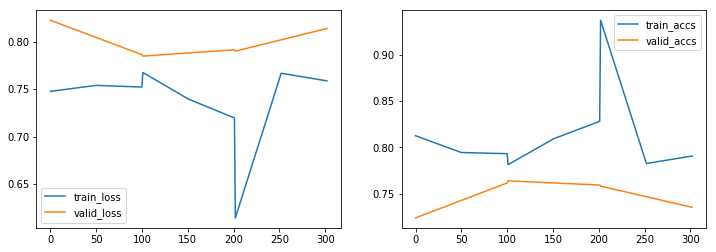

In [38]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter_list, train_loss_list, label='train_loss')
plt.plot(val_iter_list, val_loss_list, label='valid_loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter_list, train_accs_list, label='train_accs')
plt.plot(val_iter_list, val_accs_list, label='valid_accs')
plt.legend()
plt.show()

## SNLI

In [3]:
print("Run test on SNLI...")
TEXT = datasets.nli.ParsedTextField()
LABEL = data.LabelField()
TREE = datasets.nli.ShiftReduceField()

train, val, test = datasets.SNLI.splits(TEXT, LABEL, TREE)

print("Fields:", train.fields)
print("Number of examples:\n", len(train))
print("First Example instance:\n", vars(train[0]))

url = 'https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.simple.vec'
TEXT.build_vocab(train, max_size=None, vectors=Vectors('wiki.simple.vec', url=url))
#TEXT.build_vocab(train,vectors=GloVe[name='840B',dim='300'])
LABEL.build_vocab(train)


train_iter, val_iter, test_iter = data.Iterator.splits((train, val, test), batch_size=128)

#batch = next(iter(train_iter))
#print("Numericalize premises:\n", batch.premise)
#print("Numericalize hypotheses:\n", batch.hypothesis)
#print("Entailment labels:\n", batch.label)

print("Test iters function")
#train_iter, val_iter, test_iter = datasets.SNLI.iters(batch_size=128, trees=True)

batch = next(iter(train_iter))
print("Numericalize premises:\n", batch.premise)
print("Numericalize hypotheses:\n", batch.hypothesis)
print("Entailment labels:\n", batch.label)

#val_iter_set = next(iter(val_iter))


Run test on SNLI...
Fields: {'premise': <torchtext.datasets.nli.ParsedTextField object at 0x0000021FE88EAB70>, 'premise_transitions': <torchtext.datasets.nli.ShiftReduceField object at 0x0000021FE88EACC0>, 'hypothesis': <torchtext.datasets.nli.ParsedTextField object at 0x0000021FE88EAB70>, 'hypothesis_transitions': <torchtext.datasets.nli.ShiftReduceField object at 0x0000021FE88EACC0>, 'label': <torchtext.data.field.LabelField object at 0x0000021FE88EAC88>}
Number of examples:
 549367
First Example instance:
 {'premise': ['A', 'person', 'on', 'a', 'horse', 'jumps', 'over', 'a', 'broken', 'down', 'airplane', '.'], 'premise_transitions': ['shift', 'shift', 'reduce', 'shift', 'shift', 'shift', 'reduce', 'reduce', 'reduce', 'shift', 'shift', 'shift', 'shift', 'shift', 'shift', 'reduce', 'reduce', 'reduce', 'reduce', 'reduce', 'shift', 'reduce', 'reduce'], 'hypothesis': ['A', 'person', 'is', 'training', 'his', 'horse', 'for', 'a', 'competition', '.'], 'hypothesis_transitions': ['shift', 'sh

In [4]:
#TEXT.build_vocab(train)
#LABEL.build_vocab(train)
print(TEXT.vocab.vectors.size()[0])
print(len(LABEL.vocab.itos))
#print(vars(TEXT.vocab))
#print(vars(LABEL.vocab))

42392
3


In [5]:
# size of embeddings
embedding_dim = TEXT.vocab.vectors.size()[1]
num_embeddings = TEXT.vocab.vectors.size()[0]
num_classes = len(LABEL.vocab.itos)

input_dim = 100

con_dim = 200

dropout_rate = 0.2

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # use pretrained embeddings
        self.embeddings.weight.data.copy_(TEXT.vocab.vectors)
        
        
        self.input = Linear(in_features = embedding_dim,
                             out_features = input_dim,
                             bias =True)

        self.l_1 = Linear(in_features=con_dim,
                          out_features=con_dim,
                          bias=True)

        self.l_2 = Linear(in_features=con_dim,
                           out_features=con_dim,
                           bias=True)
        self.l_3 = Linear(in_features=con_dim,
                           out_features = con_dim,
                           bias =True)
        
        self.drop = nn.Dropout(p = dropout_rate)
        
        
        # output layer
        self.l_out = Linear(in_features=con_dim,
                            out_features=num_classes,
                            bias=False)
        
    def forward(self, x, y):
        out = {}
        # get embeddings

        x = self.embeddings(x[0])
        y = self.embeddings(y[0])
        
        #x = torch.cat((x,y),2)
        #x = self.drop(x)
        #y = self.drop(y)
        # mean embeddings, this is the bag of words trick
        
        
        #print(x.size())
        x = torch.sum(x, dim=0)
        #print(x.size())
        
        y = torch.sum(y, dim=0)
        
        x = torch.tanh(self.input(x))
        y = torch.tanh(self.input(y))
        
        x = torch.cat((x,y),1)
        
        # add hidden layers
        # YOUR CODE HERE!
        x = torch.tanh(self.l_1(x))
        x = torch.tanh(self.l_2(x))
        x = torch.tanh(self.l_2(x))

        # Softmax
        out['out'] = softmax(self.l_out(x), dim=1)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (embeddings): Embedding(42392, 300)
  (input): Linear(in_features=300, out_features=100, bias=True)
  (l_1): Linear(in_features=200, out_features=200, bias=True)
  (l_2): Linear(in_features=200, out_features=200, bias=True)
  (l_3): Linear(in_features=200, out_features=200, bias=True)
  (drop): Dropout(p=0.2)
  (l_out): Linear(in_features=200, out_features=3, bias=False)
)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(net.parameters(), lr=0.01)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

In [7]:
max_iter = 5000
eval_every = 500
log_every = 200

# will be updated while iterating
#tsne_plot = show(p, notebook_handle=True)

train_loss, train_accs = [], []

net.train()
for i, batch in enumerate(train_iter):
    if i % eval_every == 0:
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
       # val_meta = {'label_idx': [], 'sentences': [], 'labels': []}
        for val_batch in val_iter:
            output = net(val_batch.premise,val_batch.hypothesis)
            # batches sizes might vary, which is why we cannot just mean the batch's loss
            # we multiply the loss and accuracies with the batch's size,
            # to later divide by the total size
            #print(output['out'])
            #print(val_batch.label)
            val_losses += criterion(output['out'], val_batch.label) * val_batch.batch_size
            val_accs += accuracy(output['out'], val_batch.label) * val_batch.batch_size
            val_lengths += val_batch.batch_size
           # print(val_batch.batch_size)
            
        
        # divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        
        print("valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, get_numpy(val_losses), get_numpy(val_accs)))
        #update_plot(val_meta, 'bow', tsne_plot)
        
        net.train()
    
    output = net(batch.premise,batch.hypothesis)
    batch_loss = criterion(output['out'], batch.label)
    
    train_loss.append(get_numpy(batch_loss))
    train_accs.append(get_numpy(accuracy(output['out'], batch.label)))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    if i % log_every == 0:        
        print("train, it: {} loss: {:.2f} accs: {:.2f}".format(i, 
                                                               np.mean(train_loss), 
                                                               np.mean(train_accs)))
        # reset
        train_loss, train_accs = [], []

valid, it: 0 loss: 1.10 accs: 0.33

train, it: 0 loss: 1.10 accs: 0.34
train, it: 200 loss: 1.10 accs: 0.34
train, it: 400 loss: 1.10 accs: 0.35
valid, it: 500 loss: 1.10 accs: 0.35

train, it: 600 loss: 1.10 accs: 0.36
train, it: 800 loss: 1.10 accs: 0.39
valid, it: 1000 loss: 1.09 accs: 0.37

train, it: 1000 loss: 1.09 accs: 0.40
train, it: 1200 loss: 1.09 accs: 0.41
train, it: 1400 loss: 1.09 accs: 0.42
valid, it: 1500 loss: 1.09 accs: 0.36

train, it: 1600 loss: 1.09 accs: 0.41
train, it: 1800 loss: 1.08 accs: 0.42
valid, it: 2000 loss: 1.09 accs: 0.36

train, it: 2000 loss: 1.08 accs: 0.42
train, it: 2200 loss: 1.08 accs: 0.42
train, it: 2400 loss: 1.07 accs: 0.42
valid, it: 2500 loss: 1.09 accs: 0.35

train, it: 2600 loss: 1.07 accs: 0.43
train, it: 2800 loss: 1.07 accs: 0.43
valid, it: 3000 loss: 1.09 accs: 0.36

train, it: 3000 loss: 1.06 accs: 0.45
train, it: 3200 loss: 1.06 accs: 0.44
train, it: 3400 loss: 1.06 accs: 0.45
valid, it: 3500 loss: 1.09 accs: 0.36

train, it: 3600

In [84]:
valid_accs = []
valid_loss = []
valid_iter = []
train_accs = []
train_loss = []
train_iter = []
log_every = 200
eval_every = 1000
with open("BoWSNLI.txt","r") as f:
    for line in f:
        cleanline = line.replace("\n", "")
        cleanline = cleanline.split(" ")
        if cleanline[0] == "valid,":
            valid_iter.append(int(cleanline[2]))
            valid_loss.append(float(cleanline[4]))
            valid_accs.append(float(cleanline[6]))
        if cleanline[0] == "train,":
            train_iter.append(int(cleanline[2]))
            train_loss.append(float(cleanline[4]))
            train_accs.append(float(cleanline[6]))
            
            #print(valid_iter)
            
print(max(train_accs))
print(max(valid_accs))
print(min(valid_loss))
print(min(train_loss))


0.72
0.71
0.83
0.83


In [71]:
for i in range(2,len(train_iter)):
    if train_iter[i] == 0:
        train_iter[i] = train_iter[i-1]+1
        continue
    else:
        train_iter[i] = train_iter[i-1] + log_every


for i in range(2,len(valid_iter)):
    if valid_iter[i] == 0:
        valid_iter[i] =valid_iter[i-1]+1
        continue
    else:
        valid_iter[i] = valid_iter[i-1] + eval_every

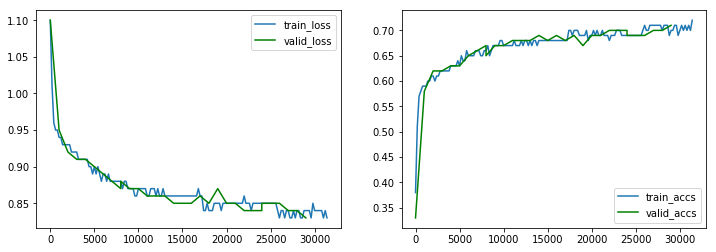

In [79]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_iter, train_loss, label='train_loss')
plt.plot(valid_iter, valid_loss, label='valid_loss',color="green")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter, train_accs, label='train_accs')
plt.plot(valid_iter, valid_accs, label='valid_accs',color="green")
plt.legend()
plt.show()